In [1]:
from __future__ import division
from __future__ import print_function

import time

import numpy as np
import scipy.sparse as sp

import networkx as nx
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score

2003
30991
30991
2003
<generator object connected_components at 0x7fd9afe59840>


/home/swyam/.local/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


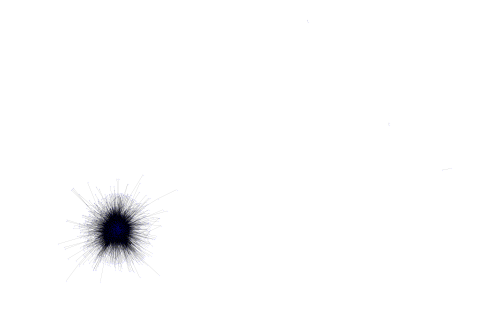

<2003x2003 sparse matrix of type '<class 'numpy.int64'>'
	with 61982 stored elements in Compressed Sparse Row format>

In [2]:
import numpy as np
import pandas as pd
def load_datax(path="da/"):
    """Load citation network dataset (cora only for now)"""
    #print('Loading {} dataset...'.format(dataset))

    idx_ = np.genfromtxt("{}{}.txt".format(path, "nodelist"),
                                        dtype=int)
    print(len(idx_))
    #features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    #labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    #idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    #idx_map = {j: i for i, j in enumerate(idx)}
    data = pd.read_csv('da/edgelist.txt', sep="(", header=None)
    col=data.columns
    data=data[col[1]]
    data = data.str.split(",",expand=True) 
    col=data.columns
    data1 = data[col[0]].str.split("{",expand=True) 
    data1=data1[data1.columns[1]]
    data2 = data[col[1]].str.split("}",expand=True)
    col=data2.columns
    #print(data1)
    data2=data2.drop(columns=col[1], axis = 1) 
    #print(data2)
    #data['new_col'] = list(zip(df.lat, df.long))
    data=pd.concat((data1,data2),axis=1)
    #data.rename(columns={data.columns[0]:'a',data.columns[1]:'b',data.columns[2]:'c'},inplace=True)
    #data = list(zip(data1, data2))
    #print(data)
    edge=[]
    for i in range(len(data.values)):
        
        edge.append((int(data.values[i][0]),int(data.values[i][1])))
    print(len(edge))
        
    G=nx.Graph()
    G.add_nodes_from(idx_)
    G.add_edges_from(edge)
    print(len(G.edges()))
    print(len(G.nodes()))
    print(nx.connected_components(G))
    options = {
    'node_color': 'blue',
    'node_size': 0.0005,
    'width':0.05,
    'arrowstyle': '-|>',
    'arrowsize': 1000,
    }
    nx.draw(G,arrows=True,**options)
    plt.savefig("graph.png", dpi=1000)
    plt.show()
    

    #print(data)

    adj=nx.adjacency_matrix(G)

    return adj
load_datax()


In [3]:
def encode_onehot(labels):
    classes = set(labels)
    classes_dict = {c: np.identity(len(classes))[i, :] for i, c in
                    enumerate(classes)}
    labels_onehot = np.array(list(map(classes_dict.get, labels)),
                             dtype=np.int32)
    return labels_onehot
def normalize(mx):
    """Row-normalize sparse matrix"""
    rowsum = np.array(mx.sum(1))
    r_inv = np.power(rowsum, -1).flatten()
    r_inv[np.isinf(r_inv)] = 0.
    r_mat_inv = sp.diags(r_inv)
    mx = r_mat_inv.dot(mx)
    return mx


def load_data(path="../cora/", dataset="cora"):
    """Load citation network dataset (cora only for now)"""
    print('Loading {} dataset...'.format(dataset))

    idx_features_labels = np.genfromtxt("{}{}.content".format(path, dataset),
                                        dtype=np.dtype(str))
    features = sp.csr_matrix(idx_features_labels[:, 1:-1], dtype=np.float32)
    labels = encode_onehot(idx_features_labels[:, -1])

    # build graph
    idx = np.array(idx_features_labels[:, 0], dtype=np.int32)
    idx_map = {j: i for i, j in enumerate(idx)}
    edges_unordered = np.genfromtxt("{}{}_cites.txt".format(path, dataset),
                                    dtype=np.int32)
    edges = np.array(list(map(idx_map.get, edges_unordered.flatten())),
                     dtype=np.int32).reshape(edges_unordered.shape)
    adj = sp.coo_matrix((np.ones(edges.shape[0]), (edges[:, 0], edges[:, 1])),
                        shape=(labels.shape[0], labels.shape[0]),
                        dtype=np.float32)

    # build symmetric adjacency matrix
    adj = adj + adj.T.multiply(adj.T > adj) - adj.multiply(adj.T > adj)

    features = normalize(features)
    #adj = normalize(adj + sp.eye(adj.shape[0]))
    """
    idx_train = range(140)
    idx_val = range(200, 500)
    idx_test = range(500, 1500)
    
    features = torch.FloatTensor(np.array(features.todense()))
    labels = torch.LongTensor(np.where(labels)[1])
    adj = sparse_mx_to_torch_sparse_tensor(adj)

    idx_train = torch.LongTensor(idx_train)
    idx_val = torch.LongTensor(idx_val)
    idx_test = torch.LongTensor(idx_test)
    """

    return adj,features


In [4]:
def del_all_flags(FLAGS):
    flags_dict = FLAGS._flags()    
    keys_list = [keys for keys in flags_dict]    
    for keys in keys_list:
        FLAGS.__delattr__(keys)
        

del_all_flags(tf.flags.FLAGS)

# Set random seed
seed = 123
np.random.seed(seed)
tf.set_random_seed(seed)

# Settings

flags = tf.app.flags
tf.app.flags.DEFINE_string('f', '', 'kernel')
FLAGS = flags.FLAGS
flags.DEFINE_float('learning_rate', 0.01, 'Initial learning rate.')
flags.DEFINE_integer('epochs', 600, 'Number of epochs to train.')
flags.DEFINE_integer('hidden1', 128, 'Number of units in hidden layer 1.')
flags.DEFINE_integer('hidden2', 64, 'Number of units in hidden layer 2.')
flags.DEFINE_float('dropout', 0.20, 'Dropout rate (1 - keep probability).')

In [5]:

def weight_variable_glorot(input_dim, output_dim, name=""):
    init_range = np.sqrt(6.0 / (input_dim + output_dim))
    initial = tf.random_uniform(
        [input_dim, output_dim], minval=-init_range,
        maxval=init_range, dtype=tf.float32)
    return tf.Variable(initial, name=name)


def dropout_sparse(x, keep_prob, num_nonzero_elems):
    noise_shape = [num_nonzero_elems]
    random_tensor = keep_prob
    random_tensor += tf.random_uniform(noise_shape)
    dropout_mask = tf.cast(tf.floor(random_tensor), dtype=tf.bool)
    pre_out = tf.sparse_retain(x, dropout_mask)
    return pre_out * (1. / keep_prob)


def sparse_to_tuple(sparse_mx):
    if not sp.isspmatrix_coo(sparse_mx):
        sparse_mx = sparse_mx.tocoo()
    coords = np.vstack((sparse_mx.row, sparse_mx.col)).transpose()
    values = sparse_mx.data
    shape = sparse_mx.shape
    return coords, values, shape


def preprocess_graph(adj):
    adj = sp.coo_matrix(adj)
    adj_ = adj + sp.eye(adj.shape[0])
    rowsum = np.array(adj_.sum(1))
    degree_mat_inv_sqrt = sp.diags(np.power(rowsum, -0.5).flatten())
    adj_normalized = adj_.dot(degree_mat_inv_sqrt).transpose().dot(degree_mat_inv_sqrt).tocoo()
    return sparse_to_tuple(adj_normalized)


def construct_feed_dict(adj_normalized, adj, features, placeholders):
    feed_dict = dict()
    feed_dict.update({placeholders['features']: features})
    feed_dict.update({placeholders['adj']: adj_normalized})
    feed_dict.update({placeholders['adj_orig']: adj})
    return feed_dict


def mask_test_edges(adj):
    # Function to build test set with 2% positive links
    # Remove diagonal elements
    adj = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
    adj.eliminate_zeros()

    adj_triu = sp.triu(adj)
    adj_tuple = sparse_to_tuple(adj_triu)
    edges = adj_tuple[0]
    edges_all = sparse_to_tuple(adj)[0]
    num_test = int(np.floor(edges.shape[0] / 50.))
    num_val = int(np.floor(edges.shape[0] / 50.))

    all_edge_idx = list(range(edges.shape[0]))
    np.random.shuffle(all_edge_idx)
    val_edge_idx = all_edge_idx[:num_val]
    test_edge_idx = all_edge_idx[num_val:(num_val + num_test)]
    test_edges = edges[test_edge_idx]
    val_edges = edges[val_edge_idx]
    train_edges = np.delete(edges, np.hstack([test_edge_idx, val_edge_idx]), axis=0)

    def ismember(a, b):
        rows_close = np.all((a - b[:, None]) == 0, axis=-1)
        return np.any(rows_close)

    test_edges_false = []
    while len(test_edges_false) < len(test_edges):
        n_rnd = len(test_edges) - len(test_edges_false)
        rnd = np.random.randint(0, adj.shape[0], size=2 * n_rnd)
        idxs_i = rnd[:n_rnd]                                        
        idxs_j = rnd[n_rnd:]
        for i in range(n_rnd):
            idx_i = idxs_i[i]
            idx_j = idxs_j[i]
            if idx_i == idx_j:
                continue
            if ismember([idx_i, idx_j], edges_all):
                continue
            if test_edges_false:
                if ismember([idx_j, idx_i], np.array(test_edges_false)):
                    continue
                if ismember([idx_i, idx_j], np.array(test_edges_false)):
                    continue
            test_edges_false.append([idx_i, idx_j])

    val_edges_false = []
    while len(val_edges_false) < len(val_edges):
        n_rnd = len(val_edges) - len(val_edges_false)
        rnd = np.random.randint(0, adj.shape[0], size=2 * n_rnd)
        idxs_i = rnd[:n_rnd]                                        
        idxs_j = rnd[n_rnd:]
        for i in range(n_rnd):
            idx_i = idxs_i[i]
            idx_j = idxs_j[i]
            if idx_i == idx_j:
                continue
            if ismember([idx_i, idx_j], train_edges):
                continue
            if ismember([idx_j, idx_i], train_edges):
                continue
            if ismember([idx_i, idx_j], val_edges):
                continue
            if ismember([idx_j, idx_i], val_edges):
                continue
            if val_edges_false:
                if ismember([idx_j, idx_i], np.array(val_edges_false)):
                    continue
                if ismember([idx_i, idx_j], np.array(val_edges_false)):
                    continue
            val_edges_false.append([idx_i, idx_j])

    # Re-build adj matrix
    data = np.ones(train_edges.shape[0])
    adj_train = sp.csr_matrix((data, (train_edges[:, 0], train_edges[:, 1])), shape=adj.shape)
    adj_train = adj_train + adj_train.T

    return adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false


def get_roc_score(edges_pos, edges_neg):
    feed_dict.update({placeholders['dropout']: 0})
    emb = sess.run(model.embeddings, feed_dict=feed_dict)

    def sigmoid(x):
        return 1 / (1 + np.exp(-x))

    # Predict on test set of edges
    adj_rec = np.dot(emb, emb.T)
    preds = []
    pos = []
    for e in edges_pos:
        preds.append(sigmoid(adj_rec[e[0], e[1]]))
        pos.append(adj_orig[e[0], e[1]])

    preds_neg = []
    neg = []
    for e in edges_neg:
        preds_neg.append(sigmoid(adj_rec[e[0], e[1]]))
        neg.append(adj_orig[e[0], e[1]])

    preds_all = np.hstack([preds, preds_neg])
    labels_all = np.hstack([np.ones(len(preds)), np.zeros(len(preds))])
    roc_score = roc_auc_score(labels_all, preds_all)
    ap_score = average_precision_score(labels_all, preds_all)

    return roc_score, ap_score

In [6]:
class GraphConvolution():
    """Basic graph convolution layer for undirected graph without edge labels."""
    def __init__(self, input_dim, output_dim, adj, name, dropout=0., act=tf.nn.relu):
        self.name = name
        self.vars = {}
        self.issparse = False
        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot(input_dim, output_dim, name='weights')
        self.dropout = dropout
        self.adj = adj
        self.act = act

    def __call__(self, inputs):
        with tf.name_scope(self.name):        
            x = inputs
            x = tf.nn.dropout(x, 1-self.dropout)
            x = tf.matmul(x, self.vars['weights'])
            x = tf.sparse_tensor_dense_matmul(self.adj, x)
            outputs = self.act(x)
        return outputs


class GraphConvolutionSparse():
    """Graph convolution layer for sparse inputs."""
    def __init__(self, input_dim, output_dim, adj, features_nonzero, name, dropout=0., act=tf.nn.relu):
        self.name = name
        self.vars = {}
        self.issparse = False
        with tf.variable_scope(self.name + '_vars'):
            self.vars['weights'] = weight_variable_glorot(input_dim, output_dim, name='weights')
        self.dropout = dropout
        self.adj = adj
        self.act = act
        self.issparse = True
        self.features_nonzero = features_nonzero

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            x = inputs
            x = dropout_sparse(x, 1-self.dropout, self.features_nonzero)
            x = tf.sparse_tensor_dense_matmul(x, self.vars['weights'])
            x = tf.sparse_tensor_dense_matmul(self.adj, x)
            outputs = self.act(x)
        return outputs
    
    
class InnerProductDecoder():
    """Decoder model layer for link prediction."""
    def __init__(self, input_dim, name, dropout=0., act=tf.nn.sigmoid):
        self.name = name
        self.issparse = False
        self.dropout = dropout
        self.act = act

    def __call__(self, inputs):
        with tf.name_scope(self.name):
            inputs = tf.nn.dropout(inputs, 1-self.dropout)
            x = tf.transpose(inputs)
            x = tf.matmul(inputs, x)
            x = tf.reshape(x, [-1])
            outputs = self.act(x)
        return outputs

In [7]:
class GCNModel():
    def __init__(self, placeholders, num_features, features_nonzero, name):
        self.name = name
        self.inputs = placeholders['features']
        self.input_dim = num_features
        self.features_nonzero = features_nonzero
        self.adj = placeholders['adj']
        self.dropout = placeholders['dropout']
        with tf.variable_scope(self.name):
            self.build()
        
    def build(self):
        self.hidden1 = GraphConvolutionSparse(
            name='gcn_sparse_layer',
            input_dim=self.input_dim,
            output_dim=FLAGS.hidden1,
            adj=self.adj,
            features_nonzero=self.features_nonzero,
            act=tf.nn.relu,
            dropout=self.dropout)(self.inputs)

        self.embeddings = GraphConvolution(
            name='gcn_dense_layer',
            input_dim=FLAGS.hidden1,
            output_dim=FLAGS.hidden2,
            adj=self.adj,
            act=lambda x: x,
            dropout=self.dropout)(self.hidden1)

        self.reconstructions = InnerProductDecoder(
            name='gcn_decoder',
            input_dim=FLAGS.hidden2, 
            act=lambda x: x)(self.embeddings)

In [8]:
class Optimizer():
    def __init__(self, preds, labels, num_nodes, num_edges):
        pos_weight = float(num_nodes**2 - num_edges) / num_edges
        norm = num_nodes**2 / float((num_nodes**2 - num_edges) * 2)
        
        preds_sub = preds
        labels_sub = labels

        self.cost = norm * tf.reduce_mean(
            tf.nn.weighted_cross_entropy_with_logits(
                logits=preds_sub, targets=labels_sub, pos_weight=pos_weight))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=FLAGS.learning_rate)  # Adam Optimizer

        self.opt_op = self.optimizer.minimize(self.cost)
        self.grads_vars = self.optimizer.compute_gradients(self.cost)

2003
30991
30991
2003
<generator object connected_components at 0x7fd9aec4c930>


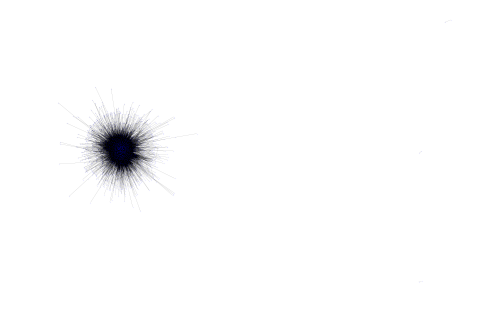

In [9]:
adj = load_datax()
#adj,features=load_data()
num_nodes = adj.shape[0]
num_edges = adj.sum()
# Featureless
features = sparse_to_tuple(sp.identity(num_nodes))
#features = sparse_to_tuple(features)
num_features = features[2][1]
features_nonzero = features[1].shape[0]

# Store original adjacency matrix (without diagonal entries) for later
adj_orig = adj - sp.dia_matrix((adj.diagonal()[np.newaxis, :], [0]), shape=adj.shape)
adj_orig.eliminate_zeros()

adj_train, train_edges, val_edges, val_edges_false, test_edges, test_edges_false = mask_test_edges(adj)
adj = adj_train

adj_norm = preprocess_graph(adj)

In [10]:
# Inspect train/test split
print ("Total nodes:", adj.shape[0])
#print "Total edges:", int(adj_sparse.nnz/2) # adj is symmetric, so nnz (num non-zero) = 2*num_edges
print ("Training edges (positive):", len(train_edges))
#print "Training edges (negative):", len(train_edges_false)
print ("Validation edges (positive):", len(val_edges))
print ("Validation edges (negative):", len(val_edges_false))
print ("Test edges (positive):", len(test_edges))
print ("Test edges (negative):", len(test_edges_false))

Total nodes: 2003
Training edges (positive): 29753
Validation edges (positive): 619
Validation edges (negative): 619
Test edges (positive): 619
Test edges (negative): 619


In [11]:
# Define placeholders
placeholders = {
    'features': tf.sparse_placeholder(tf.float32),
    'adj': tf.sparse_placeholder(tf.float32),
    'adj_orig': tf.sparse_placeholder(tf.float32),
    'dropout': tf.placeholder_with_default(0., shape=())
}

# Create model
model = GCNModel(placeholders, num_features, features_nonzero, name='cora')

# Create optimizer
with tf.name_scope('optimizer'):
    opt = Optimizer(
        preds=model.reconstructions,
        labels=tf.reshape(tf.sparse_tensor_to_dense(placeholders['adj_orig'], validate_indices=False), [-1]),
        num_nodes=num_nodes,
        num_edges=num_edges)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [12]:
# Initialize session
sess = tf.Session()
sess.run(tf.global_variables_initializer())

adj_label = adj_train + sp.eye(adj_train.shape[0])
adj_label = sparse_to_tuple(adj_label)

# Train model
for epoch in range(FLAGS.epochs):
    t = time.time()
    # Construct feed dictionary
    feed_dict = construct_feed_dict(adj_norm, adj_label, features, placeholders)
    feed_dict.update({placeholders['dropout']: FLAGS.dropout})
    # One update of parameter matrices
    _, avg_cost = sess.run([opt.opt_op, opt.cost], feed_dict=feed_dict)
    # Performance on validation set
    roc_curr, ap_curr = get_roc_score(val_edges, val_edges_false)

    print("Epoch:", '%04d' % (epoch + 1), 
          "train_loss=", "{:.5f}".format(avg_cost),
          "val_roc=", "{:.5f}".format(roc_curr),
          "val_ap=", "{:.5f}".format(ap_curr),
          "time=", "{:.5f}".format(time.time() - t))

print('Optimization Finished!')

roc_score, ap_score = get_roc_score(test_edges, test_edges_false)
print('Test ROC score: {:.5f}'.format(roc_score))
print('Test AP score: {:.5f}'.format(ap_score))

Epoch: 0001 train_loss= 0.69038 val_roc= 0.92988 val_ap= 0.93587 time= 1.08183
Epoch: 0002 train_loss= 0.68604 val_roc= 0.94893 val_ap= 0.95108 time= 0.42902
Epoch: 0003 train_loss= 0.66019 val_roc= 0.95037 val_ap= 0.95256 time= 0.38579
Epoch: 0004 train_loss= 0.60139 val_roc= 0.94970 val_ap= 0.95263 time= 0.38615
Epoch: 0005 train_loss= 0.54960 val_roc= 0.94976 val_ap= 0.95300 time= 0.39488
Epoch: 0006 train_loss= 0.59240 val_roc= 0.94916 val_ap= 0.95281 time= 0.41718
Epoch: 0007 train_loss= 0.58195 val_roc= 0.94815 val_ap= 0.95234 time= 0.41492
Epoch: 0008 train_loss= 0.54538 val_roc= 0.94735 val_ap= 0.95179 time= 0.39210
Epoch: 0009 train_loss= 0.53552 val_roc= 0.94610 val_ap= 0.95086 time= 0.38648
Epoch: 0010 train_loss= 0.54347 val_roc= 0.94465 val_ap= 0.94981 time= 0.38426
Epoch: 0011 train_loss= 0.55071 val_roc= 0.94337 val_ap= 0.94880 time= 0.41306
Epoch: 0012 train_loss= 0.55019 val_roc= 0.94249 val_ap= 0.94806 time= 0.42550
Epoch: 0013 train_loss= 0.53731 val_roc= 0.94180 val

Epoch: 0105 train_loss= 0.48647 val_roc= 0.91290 val_ap= 0.93167 time= 0.39872
Epoch: 0106 train_loss= 0.48704 val_roc= 0.91354 val_ap= 0.93211 time= 0.38667
Epoch: 0107 train_loss= 0.48651 val_roc= 0.91414 val_ap= 0.93247 time= 0.39557
Epoch: 0108 train_loss= 0.48679 val_roc= 0.91402 val_ap= 0.93243 time= 0.43165
Epoch: 0109 train_loss= 0.48757 val_roc= 0.91279 val_ap= 0.93165 time= 0.38819
Epoch: 0110 train_loss= 0.48682 val_roc= 0.91265 val_ap= 0.93156 time= 0.39605
Epoch: 0111 train_loss= 0.48752 val_roc= 0.91356 val_ap= 0.93219 time= 0.38944
Epoch: 0112 train_loss= 0.48609 val_roc= 0.91443 val_ap= 0.93277 time= 0.38954
Epoch: 0113 train_loss= 0.48952 val_roc= 0.91351 val_ap= 0.93220 time= 0.43281
Epoch: 0114 train_loss= 0.48710 val_roc= 0.91176 val_ap= 0.93106 time= 0.40003
Epoch: 0115 train_loss= 0.48629 val_roc= 0.91011 val_ap= 0.92997 time= 0.38759
Epoch: 0116 train_loss= 0.48683 val_roc= 0.90941 val_ap= 0.92955 time= 0.39727
Epoch: 0117 train_loss= 0.49062 val_roc= 0.91128 val

Epoch: 0209 train_loss= 0.48115 val_roc= 0.91323 val_ap= 0.93192 time= 0.37465
Epoch: 0210 train_loss= 0.48139 val_roc= 0.91285 val_ap= 0.93164 time= 0.39998
Epoch: 0211 train_loss= 0.48309 val_roc= 0.91446 val_ap= 0.93268 time= 0.41563
Epoch: 0212 train_loss= 0.48262 val_roc= 0.91723 val_ap= 0.93448 time= 0.37695
Epoch: 0213 train_loss= 0.48112 val_roc= 0.91927 val_ap= 0.93586 time= 0.37447
Epoch: 0214 train_loss= 0.48083 val_roc= 0.92114 val_ap= 0.93708 time= 0.36810
Epoch: 0215 train_loss= 0.48463 val_roc= 0.92092 val_ap= 0.93700 time= 0.38406
Epoch: 0216 train_loss= 0.48245 val_roc= 0.91947 val_ap= 0.93615 time= 0.41679
Epoch: 0217 train_loss= 0.48360 val_roc= 0.91658 val_ap= 0.93425 time= 0.38509
Epoch: 0218 train_loss= 0.48120 val_roc= 0.91421 val_ap= 0.93260 time= 0.37746
Epoch: 0219 train_loss= 0.48435 val_roc= 0.91403 val_ap= 0.93248 time= 0.36685
Epoch: 0220 train_loss= 0.48341 val_roc= 0.91614 val_ap= 0.93404 time= 0.38110
Epoch: 0221 train_loss= 0.48158 val_roc= 0.91847 val

Epoch: 0313 train_loss= 0.46547 val_roc= 0.93138 val_ap= 0.94443 time= 0.37626
Epoch: 0314 train_loss= 0.46173 val_roc= 0.92739 val_ap= 0.94237 time= 0.36649
Epoch: 0315 train_loss= 0.46211 val_roc= 0.92305 val_ap= 0.93976 time= 0.38187
Epoch: 0316 train_loss= 0.46209 val_roc= 0.92006 val_ap= 0.93821 time= 0.41935
Epoch: 0317 train_loss= 0.46761 val_roc= 0.92429 val_ap= 0.94096 time= 0.41011
Epoch: 0318 train_loss= 0.46219 val_roc= 0.93111 val_ap= 0.94508 time= 0.37662
Epoch: 0319 train_loss= 0.46398 val_roc= 0.93332 val_ap= 0.94620 time= 0.36793
Epoch: 0320 train_loss= 0.46360 val_roc= 0.93085 val_ap= 0.94450 time= 0.37663
Epoch: 0321 train_loss= 0.46585 val_roc= 0.92217 val_ap= 0.93934 time= 0.40512
Epoch: 0322 train_loss= 0.46033 val_roc= 0.91415 val_ap= 0.93415 time= 0.40867
Epoch: 0323 train_loss= 0.46491 val_roc= 0.91357 val_ap= 0.93401 time= 0.37600
Epoch: 0324 train_loss= 0.46758 val_roc= 0.92142 val_ap= 0.93935 time= 0.37866
Epoch: 0325 train_loss= 0.46155 val_roc= 0.93223 val

Epoch: 0417 train_loss= 0.44904 val_roc= 0.93768 val_ap= 0.95024 time= 0.40966
Epoch: 0418 train_loss= 0.44977 val_roc= 0.93564 val_ap= 0.94877 time= 0.38672
Epoch: 0419 train_loss= 0.44982 val_roc= 0.93632 val_ap= 0.94920 time= 0.37513
Epoch: 0420 train_loss= 0.45326 val_roc= 0.94124 val_ap= 0.95239 time= 0.37633
Epoch: 0421 train_loss= 0.45235 val_roc= 0.94650 val_ap= 0.95565 time= 0.40428
Epoch: 0422 train_loss= 0.45591 val_roc= 0.94705 val_ap= 0.95585 time= 0.41653
Epoch: 0423 train_loss= 0.47563 val_roc= 0.93950 val_ap= 0.95130 time= 0.37874
Epoch: 0424 train_loss= 0.44967 val_roc= 0.92284 val_ap= 0.94075 time= 0.37096
Epoch: 0425 train_loss= 0.45926 val_roc= 0.91491 val_ap= 0.93566 time= 0.37989
Epoch: 0426 train_loss= 0.45812 val_roc= 0.92106 val_ap= 0.93969 time= 0.38484
Epoch: 0427 train_loss= 0.46286 val_roc= 0.93452 val_ap= 0.94798 time= 0.40935
Epoch: 0428 train_loss= 0.45024 val_roc= 0.94173 val_ap= 0.95221 time= 0.39139
Epoch: 0429 train_loss= 0.45299 val_roc= 0.94517 val

Epoch: 0521 train_loss= 0.44507 val_roc= 0.93264 val_ap= 0.94688 time= 0.38698
Epoch: 0522 train_loss= 0.44262 val_roc= 0.93553 val_ap= 0.94895 time= 0.48271
Epoch: 0523 train_loss= 0.44516 val_roc= 0.94003 val_ap= 0.95207 time= 0.43410
Epoch: 0524 train_loss= 0.44480 val_roc= 0.94079 val_ap= 0.95274 time= 0.41160
Epoch: 0525 train_loss= 0.44399 val_roc= 0.94081 val_ap= 0.95277 time= 0.38432
Epoch: 0526 train_loss= 0.44893 val_roc= 0.93745 val_ap= 0.95069 time= 0.38740
Epoch: 0527 train_loss= 0.44361 val_roc= 0.93202 val_ap= 0.94685 time= 0.37547
Epoch: 0528 train_loss= 0.44248 val_roc= 0.92620 val_ap= 0.94285 time= 0.39977
Epoch: 0529 train_loss= 0.45106 val_roc= 0.93098 val_ap= 0.94587 time= 0.49091
Epoch: 0530 train_loss= 0.44382 val_roc= 0.93726 val_ap= 0.94974 time= 0.39513
Epoch: 0531 train_loss= 0.44377 val_roc= 0.94269 val_ap= 0.95326 time= 0.38142
Epoch: 0532 train_loss= 0.44348 val_roc= 0.94623 val_ap= 0.95541 time= 0.37470
Epoch: 0533 train_loss= 0.44607 val_roc= 0.94663 val